Copyright &copy; 2012 Ondrej Martinsky, All rights reserved

[www.quantandfinancial.com](http://www.quantandfinancial.com)
# Binomial Option Pricing

In [1]:
%pylab
%matplotlib inline
pylab.rcParams['figure.figsize'] = (10, 6)
import scipy.optimize
from pandas import *

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


### Definition of enumerators

In [2]:
call, put, european, american = 100, 101, 102, 103

### Load prices

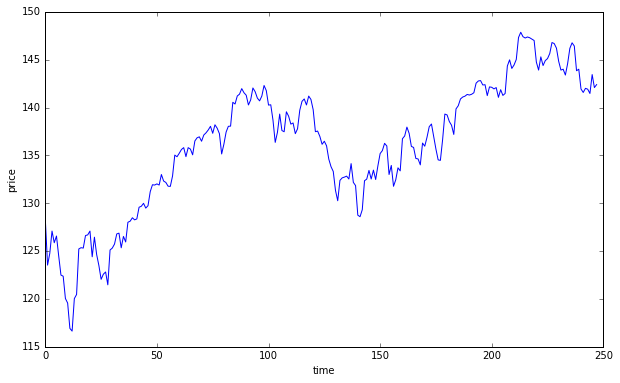

In [3]:
dataframe = pandas.read_csv('ivv_2012_11_05.csv', index_col=None, parse_dates=['date'])
prices = array(dataframe['close'])[-250:]  # We will use last 250 trading days
plot(prices), xlabel('time'), ylabel('price');

### Calculation of daily continuous asset returns
$$ r = log \left( p_t - p_{t-1} \right)$$

In [4]:
returns = log(prices[1:] / prices[:-1])

### Calculation of daily and annualized volatility from daily returns
$$ \sigma_d^2 = E \left[ \left( X - E[X] \right) ^2 \right] $$
$$ \sigma^2 = \sigma_d^2 \times 250 $$ 

In [5]:
volat_d = numpy.std(returns)  # Daily volatility
volat = sqrt(volat_d**2 * 250)  # Annualized volatility
volat

0.14855482160262648

### Calculation inputs

In [6]:
side = call  # Option side
style = american  # Option style
price = prices[-1]  # Current instrument price (147.31, as of 2012/11/05)
strike = 140  # Strike price
riskfree = .0007  # Risk-free rate, Yield on 3m US Treasury Yields, as of 2012/11/05
divyield = .0199  # Dividend yield on S&P 500 (IVV), as of 2012/11/05
tte = (datetime(2012, 12, 22) - datetime(2012, 11, 6)).days  # Time to expiration in days

print('Calculation Inputs')
print('%18s : %0.3f' % ('Price', price))
print('%18s : %0.3f' % ('Strike', strike))
print('%18s : %0.3f' % ('Risk-free', riskfree))
print('%18s : %0.3f' % ('Div Yield', divyield))
print('%18s : %0.3f' % ('TTE Days', tte))
print('%18s : %0.3f' % ('Volatility', volat))
print()

Calculation Inputs
             Price : 142.410
            Strike : 140.000
         Risk-free : 0.001
         Div Yield : 0.020
          TTE Days : 46.000
        Volatility : 0.149



### Pre-processing of inputs and calculation of per-step figures
$$  u = e^{\nu \cdot \sqrt{t_{\bigtriangleup}}} \; ; \; d = \frac{1}{u} $$

$$ v = max \left( \frac{v_u \cdot \pi_u + v_d \cdot \pi_d}{e^{r_f \cdot t_{\bigtriangleup}}} \; ; \; p - s\right) $$

In [7]:
n = 8  # Depth of binomial tree (levels are numbered from 0 to n)
tdelta = tte / (n * 365)  # Time delta per one step (as fraction of year)
u = exp(volat * tdelta ** .5)  # Up movement per step
d = 1 / u  # Down movement per step
rf = exp(riskfree * tdelta) - 1  # Risk-free rate per step
dy = exp(divyield * tdelta) - 1  # Dividend yield per step
pu = (1 + rf - dy - d) / (u - d)  # Probability of up movement
pd = 1 - pu  # Probability of down movement

assert side in [call, put] and style in [american, european]
print('%18s : %0.8f' % ('Node prob U', pu))
print('%18s : %0.8f' % ('Node prob D', pd))
print('%18s : %0.8f' % ('Node tdelta', tdelta))
print('%18s : %0.8f' % ('Node discount f', rf))

       Node prob U : 0.48722696
       Node prob D : 0.51277304
       Node tdelta : 0.01575342
   Node discount f : 0.00001103


In [8]:
print('Binomial Tree')
# Generate terminal nodes of binomial tree
level = []
print()
for j in range(0, n + 1):  # Iterate through nodes from highest to lowest price
    # Instrument's price at the node
    pr = price * d ** j * u ** (n - j)
    # Option value at the node (depending on side)
    ov = max(0.0, pr - strike) if side == call else max(0.0, strike - pr)
    level.append((pr, ov))
    print('Node [%i,%i] \t Price %6.3f \t Option Value %6.3f' % (n, j, pr, ov))

levels = [None, None, None]  # Remember levels 0,1,2 for the greeks

# reduce binomial tree
for i in range(n - 1, -1, -1):  # [n-1 to 0]
    levelNext = []
    print()
    for j in range(0, i + 1):  # Iterate through nodes from highest to lowest price
        node_u, node_d = level[j], level[j + 1]
        # Instrument's price at the node
        pr = node_d[0] / d
        # Option value at the node (depending on side)
        ov = (node_d[1] * pd + node_u[1] * pu) / (1 + rf)
        if style == american:  # American options can be exercised anytime
            ov = max(ov, pr - strike if side == call else strike - pr)
        levelNext.append((pr, ov))
        print('Node [%i,%i] \t Price %6.3f \t Option Value %6.3f' % (i, j, pr, ov))
    level = levelNext
    if j <= 2: levels[j] = level  # save level 0,1,2 of the tree

Binomial Tree

Node [8,0] 	 Price 165.319 	 Option Value 25.319
Node [8,1] 	 Price 159.267 	 Option Value 19.267
Node [8,2] 	 Price 153.437 	 Option Value 13.437
Node [8,3] 	 Price 147.821 	 Option Value  7.821
Node [8,4] 	 Price 142.410 	 Option Value  2.410
Node [8,5] 	 Price 137.197 	 Option Value  0.000
Node [8,6] 	 Price 132.175 	 Option Value  0.000
Node [8,7] 	 Price 127.337 	 Option Value  0.000
Node [8,8] 	 Price 122.676 	 Option Value  0.000

Node [7,0] 	 Price 162.265 	 Option Value 22.265
Node [7,1] 	 Price 156.325 	 Option Value 16.325
Node [7,2] 	 Price 150.603 	 Option Value 10.603
Node [7,3] 	 Price 145.090 	 Option Value  5.090
Node [7,4] 	 Price 139.779 	 Option Value  1.174
Node [7,5] 	 Price 134.663 	 Option Value  0.000
Node [7,6] 	 Price 129.734 	 Option Value  0.000
Node [7,7] 	 Price 124.985 	 Option Value  0.000

Node [6,0] 	 Price 159.267 	 Option Value 19.267
Node [6,1] 	 Price 153.437 	 Option Value 13.437
Node [6,2] 	 Price 147.821 	 Option Value  7.821
Nod

### Read option value and greeks from the binomial tree

**Delta** is the rate of change of option's value with respect to changes in underlying instrument's price. Looking to the figure above, this rate is derived from nodes 10 and 11 as follows:

$$ \delta =\frac{v_{10} - v_{11}}{p_{10} - p_{11}} $$

**Gamma** s a rate of change of option's delta with respect to changes in underlying instrument's price. Again, we first need to calculate deltas in nodes 10 and 11:
$$ \delta_{10} =\frac{v_{20} - v_{21}}{p_{20} - p_{21}} \; ; \; \delta_{11} =\frac{v_{21} - v_{22}}{p_{21} - p_{22}} $$
Gamma is then calculated as:
$$ \gamma = \frac{\delta_{10}-\delta_{11}}{p_{10} - p_{11}}$$

**Theta**

$$ \theta = \frac{v_{21} - v_{00}}{2 \times t_{\bigtriangleup}} $$

In [9]:
optionvalue = levels[0][0][1]
delta = (levels[1][0][1] - levels[1][1][1]) / (levels[1][0][0] - levels[1][1][0])
delta1 = (levels[2][0][1] - levels[2][1][1]) / (levels[2][0][0] - levels[2][1][0])
delta2 = (levels[2][1][1] - levels[2][2][1]) / (levels[2][1][0] - levels[2][2][0])
gamma = (delta1 - delta2) / (levels[2][0][0] - levels[2][2][0])
theta = (levels[2][1][1] - optionvalue) / (2 * tdelta)

print()
print('Results')
print('Option Value %.03f' % optionvalue)
print('Delta %.03f' % delta)
print('Gamma %.03f' % gamma)
print('Theta %.03f' % theta)


Results
Option Value 4.244
Delta 0.627
Gamma 0.027
Theta -10.194
